In [1]:
from google.colab import drive
import tarfile
import os, cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.utils import np_utils
drive.mount('/content/drive'),

Mounted at /content/drive


(None,)

In [2]:
data_path = '/content/drive/MyDrive/facial_expression/jaffe'
data_dir_list = os.listdir(data_path)

img_si=128
img_siAlexNet=227
img_siAlexGoogLeNet=224
num_channel=1

num_epoch=10

img_data_listAlexNet=[]
img_data_listGoogLeNet=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resizeAlexNet=cv2.resize(input_img,(img_siAlexNet,img_siAlexNet))
        input_img_resizeGoogLeNet=cv2.resize(input_img,(img_siAlexGoogLeNet,img_siAlexGoogLeNet))
        img_data_listAlexNet.append(input_img_resizeAlexNet)
        img_data_listGoogLeNet.append(input_img_resizeGoogLeNet)
        
img_dataAlexNet = np.array(img_data_listAlexNet)
img_dataGoogLeNet = np.array(img_data_listGoogLeNet)
img_dataAlexNet = img_dataAlexNet.astype('float32')
img_dataGoogLeNet = img_dataGoogLeNet.astype('float32')
img_dataAlexNet = img_dataAlexNet/255
img_dataGoogLeNet = img_dataGoogLeNet/255
img_dataAlexNet.shape
img_dataGoogLeNet.shape

Loaded the images of dataset-ANGRY

Loaded the images of dataset-DISGUST

Loaded the images of dataset-FEAR

Loaded the images of dataset-NEUTRAL

Loaded the images of dataset-HAPPY

Loaded the images of dataset-SAD

Loaded the images of dataset-SURPRISE



(213, 224, 224, 3)

In [3]:
num_classes = 7

num_of_samples = img_dataGoogLeNet.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:29]=0 #30
labels[30:58]=1 #29
labels[59:90]=2 #32
labels[91:121]=3 #31
labels[122:151]=4 #30
labels[152:182]=5 #31
labels[183:]=6 #30

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

In [4]:
Y = np_utils.to_categorical(labels, num_classes)
#Shuffle the dataset
x,y = shuffle(img_dataGoogLeNet,Y, random_state=2)
xA,yA = shuffle(img_dataAlexNet,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
X_trainA, X_testA, y_trainA, y_testA = train_test_split(xA, yA, test_size=0.2, random_state=2)
x_test=X_test
x_testA=X_testA
#X_train=X_train.reshape(X_train.shape[0],128,128,1)
#X_test=X_test.reshape(X_test.shape[0],128,128,1)
x_test.shape

(43, 224, 224, 3)

In [5]:
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras import regularizers

In [6]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD

In [7]:
modelVGG = tf.keras.applications.VGG19(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling="max",
    classes=7,
    classifier_activation="softmax",
)

In [8]:
modelResNet = tf.keras.applications.ResNet101(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling="max",
    classes=7,
)

In [9]:
modelAlexNet = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [10]:
CLASS_NUM = 7
IMAGE_SHAPE = (224, 224, 3)

def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

# train model
modelGoogLeNet = googlenet()

In [11]:
modelVGG.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [12]:
modelResNet.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [13]:
modelAlexNet.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [14]:
modelGoogLeNet.compile(loss='categorical_crossentropy', loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3}, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [15]:
from keras import callbacks
filename1='modelVGG_train_new.csv'
filename4='modelResNet_train_new.csv'
filename16='model1AlexNet_train_new.csv'
filename32='modelGoogLeNet_train_new.csv'

filepath1 = os.path.join('checkpoint', filename1)
filepath4 = os.path.join('checkpoint', filename4)
filepath16 = os.path.join('checkpoint', filename16)
filepath32 = os.path.join('checkpoint', filename32)

checkpoint1 = callbacks.ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
checkpoint4 = callbacks.ModelCheckpoint(filepath4, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
checkpoint16 = callbacks.ModelCheckpoint(filepath16, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
checkpoint32 = callbacks.ModelCheckpoint(filepath32, monitor='val_main_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [16]:
checkpoint1 = callbacks.ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

In [17]:
hist1 = modelVGG.fit(X_train, y_train, batch_size=7, epochs=30, verbose=1, validation_data=(X_test, y_test),callbacks=checkpoint1)

Epoch 1/30
25/25 [==============================] - 41s 322ms/step - loss: 1.9472 - accuracy: 0.1412 - val_loss: 1.9483 - val_accuracy: 0.0465

Epoch 00001: val_accuracy improved from -inf to 0.04651, saving model to checkpoint/modelVGG_train_new.csv
INFO:tensorflow:Assets written to: checkpoint/modelVGG_train_new.csv/assets
Epoch 2/30
25/25 [==============================] - 6s 229ms/step - loss: 1.9460 - accuracy: 0.1647 - val_loss: 1.9545 - val_accuracy: 0.0465

Epoch 00002: val_accuracy did not improve from 0.04651
Epoch 3/30
25/25 [==============================] - 6s 229ms/step - loss: 1.9449 - accuracy: 0.1647 - val_loss: 1.9574 - val_accuracy: 0.0465

Epoch 00003: val_accuracy did not improve from 0.04651
Epoch 4/30
25/25 [==============================] - 6s 231ms/step - loss: 1.9436 - accuracy: 0.1647 - val_loss: 1.9634 - val_accuracy: 0.0465

Epoch 00004: val_accuracy did not improve from 0.04651
Epoch 5/30
25/25 [==============================] - 6s 230ms/step - loss: 1.950

In [18]:
hist2 = modelResNet.fit(X_train, y_train, batch_size=7, epochs=30, verbose=1, validation_data=(X_test, y_test),callbacks=checkpoint4)

Epoch 1/30
25/25 [==============================] - 19s 366ms/step - loss: 2.5423 - accuracy: 0.1647 - val_loss: 1.9403 - val_accuracy: 0.2093

Epoch 00001: val_accuracy improved from -inf to 0.20930, saving model to checkpoint/modelResNet_train_new.csv


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: checkpoint/modelResNet_train_new.csv/assets
Epoch 2/30
25/25 [==============================] - 6s 224ms/step - loss: 2.1534 - accuracy: 0.1706 - val_loss: 1.9823 - val_accuracy: 0.2093

Epoch 00002: val_accuracy did not improve from 0.20930
Epoch 3/30
25/25 [==============================] - 6s 234ms/step - loss: 2.0119 - accuracy: 0.2000 - val_loss: 2.0295 - val_accuracy: 0.1163

Epoch 00003: val_accuracy did not improve from 0.20930
Epoch 4/30
25/25 [==============================] - 6s 223ms/step - loss: 1.9223 - accuracy: 0.2294 - val_loss: 2.3993 - val_accuracy: 0.1163

Epoch 00004: val_accuracy did not improve from 0.20930
Epoch 5/30
25/25 [==============================] - 6s 225ms/step - loss: 1.9715 - accuracy: 0.2294 - val_loss: 2.9301 - val_accuracy: 0.0465

Epoch 00005: val_accuracy did not improve from 0.20930
Epoch 6/30
25/25 [==============================] - 6s 228ms/step - loss: 1.7674 - accuracy: 0.2882 - val_loss: 5.6607 - val_accu

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: checkpoint/modelResNet_train_new.csv/assets
Epoch 19/30
25/25 [==============================] - 6s 226ms/step - loss: 1.1718 - accuracy: 0.5706 - val_loss: 10.0126 - val_accuracy: 0.0930

Epoch 00019: val_accuracy did not improve from 0.23256
Epoch 20/30
25/25 [==============================] - 6s 226ms/step - loss: 1.0484 - accuracy: 0.6059 - val_loss: 4.0800 - val_accuracy: 0.1163

Epoch 00020: val_accuracy did not improve from 0.23256
Epoch 21/30
25/25 [==============================] - 6s 236ms/step - loss: 0.9994 - accuracy: 0.6118 - val_loss: 5.6734 - val_accuracy: 0.1860

Epoch 00021: val_accuracy did not improve from 0.23256
Epoch 22/30
25/25 [==============================] - 6s 228ms/step - loss: 0.8903 - accuracy: 0.7059 - val_loss: 6.7907 - val_accuracy: 0.2326

Epoch 00022: val_accuracy did not improve from 0.23256
Epoch 23/30
25/25 [==============================] - 6s 229ms/step - loss: 0.7717 - accuracy: 0.6824 - val_loss: 6.0397 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: checkpoint/modelResNet_train_new.csv/assets
Epoch 29/30
25/25 [==============================] - 6s 225ms/step - loss: 0.6984 - accuracy: 0.7588 - val_loss: 3.4896 - val_accuracy: 0.3023

Epoch 00029: val_accuracy improved from 0.27907 to 0.30233, saving model to checkpoint/modelResNet_train_new.csv


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: checkpoint/modelResNet_train_new.csv/assets
Epoch 30/30
25/25 [==============================] - 6s 224ms/step - loss: 0.4855 - accuracy: 0.8176 - val_loss: 5.9629 - val_accuracy: 0.2326

Epoch 00030: val_accuracy did not improve from 0.30233


In [19]:
hist3 = modelAlexNet.fit(X_trainA, y_trainA, batch_size=7, epochs=30, verbose=1, validation_data=(X_testA, y_testA),callbacks=checkpoint16)

Epoch 1/30
25/25 [==============================] - 3s 69ms/step - loss: 7.4755 - accuracy: 0.1059 - val_loss: 1.9690 - val_accuracy: 0.2093

Epoch 00001: val_accuracy improved from -inf to 0.20930, saving model to checkpoint/model1AlexNet_train_new.csv
INFO:tensorflow:Assets written to: checkpoint/model1AlexNet_train_new.csv/assets
Epoch 2/30
25/25 [==============================] - 1s 43ms/step - loss: 8.4081 - accuracy: 0.1412 - val_loss: 1.9685 - val_accuracy: 0.2093

Epoch 00002: val_accuracy did not improve from 0.20930
Epoch 3/30
25/25 [==============================] - 1s 42ms/step - loss: 6.0649 - accuracy: 0.1824 - val_loss: 2.1243 - val_accuracy: 0.0930

Epoch 00003: val_accuracy did not improve from 0.20930
Epoch 4/30
25/25 [==============================] - 1s 42ms/step - loss: 4.7022 - accuracy: 0.2529 - val_loss: 2.0705 - val_accuracy: 0.2093

Epoch 00004: val_accuracy did not improve from 0.20930
Epoch 5/30
25/25 [==============================] - 1s 43ms/step - loss: 4

In [20]:
hist4 = modelGoogLeNet.fit(X_train, y_train, batch_size=7, epochs=30, verbose=1, validation_data=(X_test, y_test),callbacks=checkpoint32)

Epoch 1/30
25/25 [==============================] - 9s 156ms/step - loss: 3.2291 - main_loss: 1.9879 - aux1_loss: 2.1688 - aux2_loss: 1.9685 - main_accuracy: 0.1765 - aux1_accuracy: 0.1647 - aux2_accuracy: 0.1000 - val_loss: 3.1123 - val_main_loss: 1.9443 - val_aux1_loss: 1.9466 - val_aux2_loss: 1.9467 - val_main_accuracy: 0.2093 - val_aux1_accuracy: 0.2093 - val_aux2_accuracy: 0.0930

Epoch 00001: val_main_accuracy improved from -inf to 0.20930, saving model to checkpoint/modelGoogLeNet_train_new.csv
INFO:tensorflow:Assets written to: checkpoint/modelGoogLeNet_train_new.csv/assets
Epoch 2/30
25/25 [==============================] - 2s 66ms/step - loss: 3.1566 - main_loss: 1.9790 - aux1_loss: 1.9669 - aux2_loss: 1.9583 - main_accuracy: 0.1176 - aux1_accuracy: 0.1294 - aux2_accuracy: 0.1588 - val_loss: 3.1159 - val_main_loss: 1.9470 - val_aux1_loss: 1.9493 - val_aux2_loss: 1.9472 - val_main_accuracy: 0.2093 - val_aux1_accuracy: 0.0465 - val_aux2_accuracy: 0.0698

Epoch 00002: val_main_a

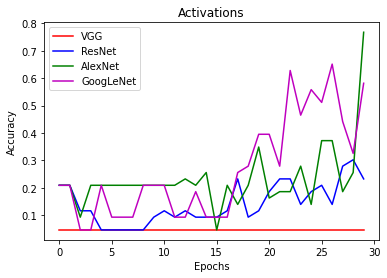

<Figure size 432x288 with 0 Axes>

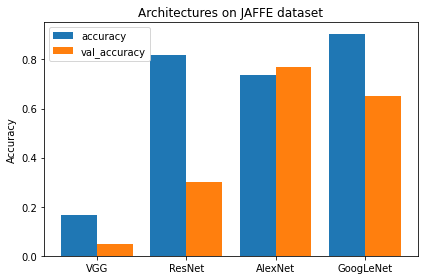

In [21]:
train_loss=hist1.history['loss']
val_loss=hist1.history['val_loss']
train_acc=hist1.history['accuracy']

val_acc=hist1.history['val_accuracy']
bval_acc=hist2.history['val_accuracy']
cval_acc=hist3.history['val_accuracy']
dval_acc=hist4.history['val_main_accuracy']

epochs = range(len(train_acc))

pyplot.plot(epochs,val_acc,'r', label='VGG')
pyplot.plot(epochs,bval_acc,'b', label='ResNet')
pyplot.plot(epochs,cval_acc,'g', label='AlexNet')
pyplot.plot(epochs,dval_acc,'m', label='GoogLeNet')
pyplot.title('Activations')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epochs')
pyplot.legend()
pyplot.figure()

labels = ['VGG', 'ResNet', 'AlexNet', 'GoogLeNet']
accuracy = [np.amax(hist1.history['accuracy']),
             np.amax(hist2.history['accuracy']),
             np.amax(hist3.history['accuracy']),
             np.amax(hist4.history['main_accuracy'])]
                       
val_accuracy = [np.amax(hist1.history['val_accuracy']),
             np.amax(hist2.history['val_accuracy']),
             np.amax(hist3.history['val_accuracy']),
             np.amax(hist4.history['val_main_accuracy'])]

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy, width, label='accuracy')
rects2 = ax.bar(x + width/2, val_accuracy, width, label='val_accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Architectures on JAFFE dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()